# Data analysis for the paper: Autonomous Platform for Solution Processing of Electronic Polymers

## Install and import required packages

In [ ]:
!pip install shap
!pip install umap-learn
!pip install cmasher
!pip install scikit-learn
!pip install plotly

In [ ]:
# If you want to use the auto-sklearn functionality in colab then run this code and then restart runtime
!pip install Cython==0.29.36
!pip uninstall scipy -y
!pip install scipy==1.9
!pip uninstall pyparsing -y
!pip install pyparsing==2.4
!pip uninstall scikit_learn -y
!pip uninstall imbalanced-learn -y
!pip uninstall mlxtend -y
!pip uninstall yellowbrick -y
!pip install scikit-learn==0.24.2 --no-build-isolation
!pip install auto-sklearn

In [4]:
import itertools
import pickle
import re
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.figure_factory as ff
import shap
import sklearn
import umap
from matplotlib.collections import LineCollection
from matplotlib.path import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
from scipy.stats import gaussian_kde
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR
import autosklearn.regression
%matplotlib inline

## Import experimental data

In [ ]:
pedot_data = pd.read_csv('PEDOT_experiment.csv')
pedot_data

In [6]:
pedot_training_data = pedot_data[pedot_data['Dataset'] == 'Train']
pedot_test_data = pedot_data[pedot_data['Dataset'] == 'Test']

pedot_param_keys = [
    'DMSO concentration (Vol%)',
    'EG concentration (Vol%)',
    'Coating speed (mm/sec)',
    'Coating temperature (Celsius)',
    'Post-processing solvent No.',
    'Post coating speed (mm/sec)',
    'Post coating temperature (Celsius)',
]

pedot_output_keys = [
        "Average coverage (%)",
        "Average conductivity (S/cm)",
]

## simulate the experimental surface: Supporting Information Section 5 + Figure 4d

In [7]:
def load_figure_params():
    plt.rcParams['axes.facecolor'] = 'white'
    plt.style.use('default')
    plt.rcParams["font.weight"] = "normal"
    plt.rcParams["axes.labelweight"] = "normal"
    plt.rcParams["axes.labelsize"] = "medium"
    plt.rcParams["axes.labelweight"] = "normal"
    plt.rcParams["xtick.labelsize"] = "medium"
    plt.rcParams["ytick.labelsize"] = "medium"
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.grid'] = False
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"] = 1.25
    plt.grid(False)
    plt.rcParams['axes.spines.top'] = True
    plt.rcParams['axes.spines.bottom'] = True
    plt.rcParams['axes.spines.left'] = True
    plt.rcParams['axes.spines.right'] = True
    ax.tick_params(axis='both', which='both', width=2)
    ax.tick_params(axis='both', which='major', length=12)
    ax.tick_params(axis='both', which='minor', length=6, color='black')
    ax.tick_params(
        axis='both',
        which='both',
        bottom=True,
        top=True,
        left=True,
        right=True,
        direction="in",
    )

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    return plt

### Train only

In [8]:
# Scalling the datasets
scaler = StandardScaler()
pedot_params = pedot_training_data[pedot_param_keys]
experimenal_space_scaled = scaler.fit_transform(pedot_params.values)
experimenal_space_scaled = pd.DataFrame(experimenal_space_scaled, columns=pedot_params.columns)

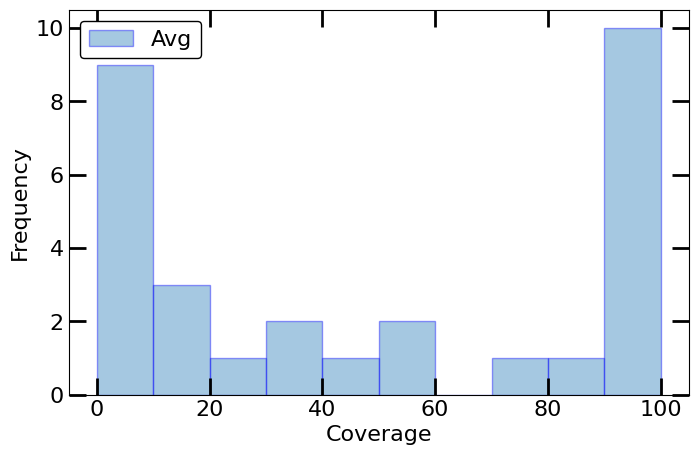

In [9]:
plt = load_figure_params()
plt.xlabel('Coverage', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.hist(
    pedot_training_data['Average coverage (%)'], alpha=0.4, edgecolor='b', label='Avg'
)
plt.legend(
    prop={'size': 16}, facecolor='white', edgecolor='black', framealpha=1
)

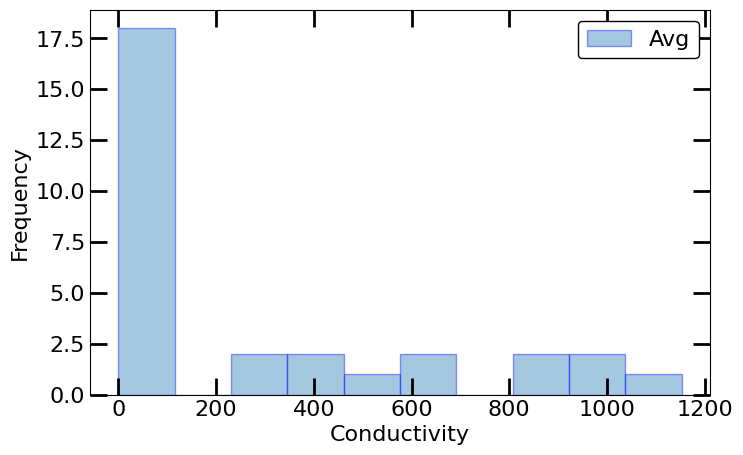

In [10]:
plt = load_figure_params()
plt.xlabel('Conductivity', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.hist(
    pedot_training_data['Average conductivity (S/cm)'],
    alpha=0.4,
    edgecolor='b',
    label='Avg',
)
plt.legend(
    prop={'size': 16}, facecolor='white', edgecolor='black', framealpha=1
)
# plt.savefig('conductivity.png', dpi=600)

In [20]:
# Define the bin split for better splitting
hist, bin_edges = np.histogram(
    pedot_training_data['Average conductivity (S/cm)'], bins='auto'
)
print('hist, bin_edges', hist, bin_edges)


def map_float_to_class(number):
    if bin_edges[0] <= number < bin_edges[1] / 4:
        return 0
    elif bin_edges[1] / 4 <= number:
        return 1

hist, bin_edges [18  2  3  2  3  2] [3.55859460e-02 1.92193959e+02 3.84352332e+02 5.76510705e+02
 7.68669079e+02 9.60827452e+02 1.15298582e+03]


Conductivity investigation on train data

In [22]:
# Compare models on conductivity prediction on the train data

models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor(n_neighbors=5)))
models.append(('SVR', SVR(kernel="rbf", C=10, gamma="auto", epsilon=0.1)))
models.append(
    ('Random Forest', RandomForestRegressor(max_depth=8, random_state=1))
)

results = []
names = []

X, y = (
    experimenal_space_scaled.iloc[:, :],
    pedot_training_data[['Average conductivity (S/cm)']],
)
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=1,
    stratify=[
        map_float_to_class(y) for y in pedot_training_data['Average conductivity (S/cm)']
    ],
)

# Make predictions on the test dataset
for name, model in models:
    pipeline = Pipeline([('model', model)])
    pipeline.fit(X_train, y_train.values.ravel())
    y_pred = pipeline.predict(X_test)
    score = r2_score(y_test, y_pred)
    print(f"{name} - Test Set R-squared: {score}")

LR - Test Set R-squared: -0.4177821395404615
KNN - Test Set R-squared: -0.011320635224600029
SVR - Test Set R-squared: -0.44649701341482917
Random Forest - Test Set R-squared: -0.8280621285288845


In [23]:
# Initialize the Auto-sklearn regressor
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=5 * 60,  # Run for 120 seconds
    per_run_time_limit=60,  # Spend a maximum of 30 seconds for each model
    n_jobs=-1,  # Use all available cores
)

# Train the model
automl.fit(X_train, y_train)
# Train the model
automl.refit(X_train, y_train)

y_pred = automl.predict(X_test)
print("R2 score:", r2_score(y_test, y_pred))

R2 score: -5.320168640334933


Coverage investigation on train data

In [44]:
X, y = (
    experimenal_space_scaled.iloc[:, :-3],
    pedot_training_data[['Average coverage (%)']],
)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=1,
    stratify=[
        map_float_to_class(y) for y in pedot_training_data['Average conductivity (S/cm)']
    ],
)

# Prepare models
models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor(n_neighbors=5)))
models.append(('SVR', SVR(kernel="rbf", C=100, gamma="auto", epsilon=0.1)))
models.append(
    ('Random Forest', RandomForestRegressor(max_depth=8, random_state=1))
)

# Evaluate each model in turn using LOCO
results = []
names = []

# Make predictions on the test dataset
for name, model in models:
    pipeline = Pipeline([('model', model)])
    pipeline.fit(X_train, y_train.values.ravel())
    y_pred = pipeline.predict(X_test)
    score = r2_score(y_test, y_pred)
    print(f"{name} - Test Set R-squared: {score}")

LR - Test Set R-squared: 0.5971103705767622
KNN - Test Set R-squared: 0.7024091393257164
SVR - Test Set R-squared: 0.5617059675977755
Random Forest - Test Set R-squared: 0.7601196458041666


In [45]:
# Initialize the Auto-sklearn regressor
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=2 * 60,  # Run for 120 seconds
    per_run_time_limit=60,  # Spend a maximum of 30 seconds for each model
    n_jobs=-1,  # Use all available cores
)

# Train the model
automl.fit(X_train, y_train)

# Evaluate
y_pred = automl.predict(X_test)
print("R2 score:", r2_score(y_test, y_pred))

R2 score: 0.7553702645196148


In [33]:
rf_coverage_reg = RandomForestRegressor(max_depth=8, random_state=1)
rf_coverage_reg.fit(X_train, y_train)
y_pred_train = rf_coverage_reg.predict(X_train)
y_pred = rf_coverage_reg.predict(X_test)
print('R2 score (train): {:.2f}'.format(r2_score(y_train, y_pred_train)))
print('R2 score (test): {:.2f}'.format(r2_score(y_test, y_pred)))

R2 score (train): 0.89
R2 score (test): 0.76


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


  0%|          | 0/30 [00:00<?, ?it/s]

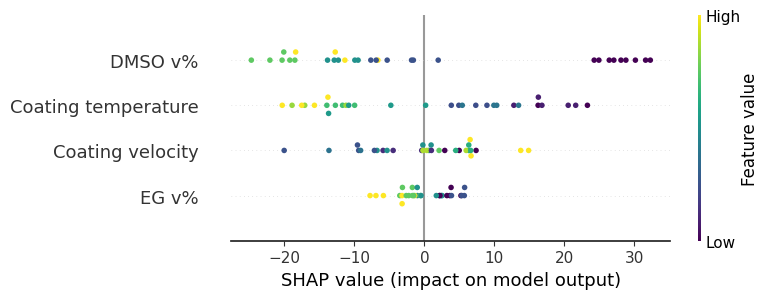

In [34]:

explainer = shap.KernelExplainer(
    model=rf_coverage_reg.predict, data=X
)  # , link = "identity")
shap_values = explainer.shap_values(X)

shap.summary_plot(
    shap_values=shap_values,
    features=X,
    cmap='viridis',
    feature_names=[
        'DMSO v%',
        'EG v%',
        'Coating velocity',
        'Coating temperature',
    ],  #
)
# plt.savefig("shap_summary1_actual.png") #,dpi=700)

### All data (Train and test) + shapley plots

In [46]:
# Scalling the datasets
pedot_params = pedot_data[pedot_param_keys]
scaler = StandardScaler()
experimenal_space_scaled = scaler.fit_transform(pedot_params.values)
experimenal_space_scaled = pd.DataFrame(
    experimenal_space_scaled, columns=pedot_params.columns.values
)

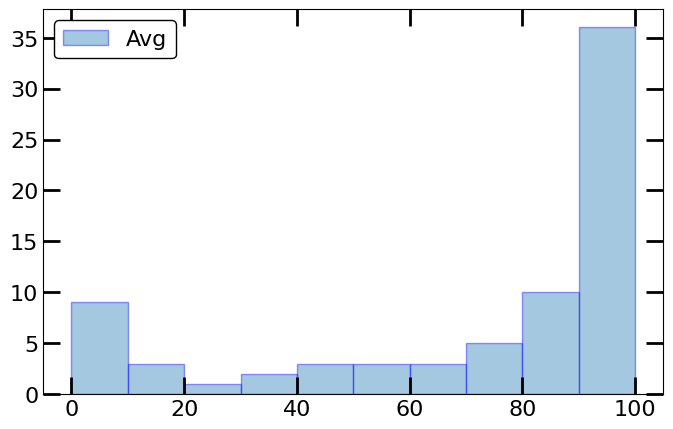

In [47]:
load_figure_params()
plt.hist(
    pedot_data['Average coverage (%)'], alpha=0.4, edgecolor='b', label='Avg'
)
plt.legend(
    prop={'size': 16}, facecolor='white', edgecolor='black', framealpha=1
)
# plt.savefig('coverage.png', dpi=600)

In [48]:
hist, bin_edges = np.histogram(
    pedot_data['Average conductivity (S/cm)'], bins='fd'
)
hist, bin_edges

(array([24, 19, 20, 11,  1]),
 array([3.55859460e-02, 3.97762980e+02, 7.95490375e+02, 1.19321777e+03,
        1.59094516e+03, 1.98867256e+03]))

In [49]:
def map_float_to_class(number):
    if bin_edges[0] <= number < bin_edges[1]:
        return 0
    elif bin_edges[1] <= number < bin_edges[2]:
        return 1
    elif bin_edges[2] <= number < bin_edges[3]:
        return 2
    elif bin_edges[3] <= number <= bin_edges[4]:
        return 3
    else:
        return 2

In [50]:
# Model comparisons for conductivity prediction
models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor(n_neighbors=8)))
models.append(('SVR', SVR(kernel="rbf", C=300, gamma="auto", epsilon=0.8)))
models.append(
    (
        'Random Forest',
        RandomForestRegressor(n_estimators=60, max_depth=10, random_state=1),
    )
)

X, y = (
    experimenal_space_scaled.iloc[:, :],
    pedot_data[['Average conductivity (S/cm)']],
)
X_train, X_test, y_train_cond, y_test_cond = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=1,
    stratify=[
        map_float_to_class(y) for y in pedot_data['Average conductivity (S/cm)']
    ],
)
results = []
names = []
for name, model in models:
    pipeline = Pipeline([('scaler', scaler), ('model', model)])
    pipeline.fit(X_train, y_train_cond.values.ravel())
    y_pred = pipeline.predict(X_test)
    score = r2_score(y_test_cond, y_pred)
    print(f"{name} - Test Set R-squared: {score}")

LR - Test Set R-squared: 0.5660458358011451
KNN - Test Set R-squared: 0.6417215059302974
SVR - Test Set R-squared: 0.7722547832983354
Random Forest - Test Set R-squared: 0.7572184938678966


In [51]:
reg = RandomForestRegressor(n_estimators=60, max_depth=10, random_state=1)
reg.fit(X_train, y_train_cond)
y_pred_train_cond = reg.predict(X_train)
y_pred_cond = reg.predict(X_test)
print('R2 score:', r2_score(y_train_cond, y_pred_train_cond))

print('R2 score: {:.2f}'.format(r2_score(y_test_cond, y_pred_cond)))

R2 score: 0.9054281373010573
R2 score: 0.75


<ipython-input-51-06f33a5dce10>:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [52]:
explainer = shap.KernelExplainer(
    model=reg.predict, data=X
)  # , link = "identity")
# shap_values = explainer(X.values)

  0%|          | 0/75 [00:00<?, ?it/s]

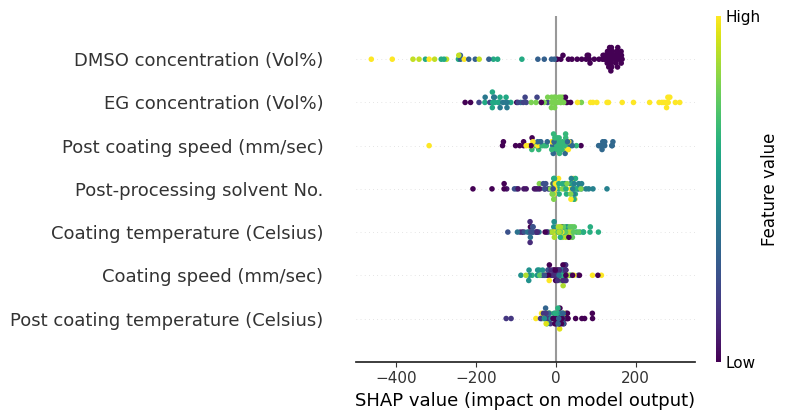

In [53]:
explainer = shap.KernelExplainer(
    model=reg.predict, data=X
)  # , link = "identity")
shap_values = explainer.shap_values(X)
shap.summary_plot(
    shap_values=shap_values, features=X, cmap='viridis'
)  # , feature_names= ['DMSO v%', 'EG v%', 'Coating velocity', 'Coating temperature', 'Post-processing solution','Post-processing coating speed', 'Post-processing coating temperature'], #
#   )

In [55]:
# Model comparisons for coverage prediction

models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor(n_neighbors=10)))
models.append(('SVR', SVR(kernel="rbf", C=300, gamma="auto", epsilon=0.8)))
models.append(
    (
        'Random Forest',
        RandomForestRegressor(n_estimators=60, max_depth=10, random_state=1),
    )
)

X, y = (
    experimenal_space_scaled.iloc[:, :-3],
    pedot_data[['Average coverage (%)']],
)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=0,
    stratify=[
        map_float_to_class(y) for y in pedot_data['Average conductivity (S/cm)']
    ],
)
# Evaluate each model in turn using LOCO
results = []
names = []
# Make predictions on the test dataset
for name, model in models:
    pipeline = Pipeline([('scaler', scaler), ('model', model)])
    pipeline.fit(X_train, y_train.values.ravel())
    y_pred = pipeline.predict(X_test)
    score = r2_score(y_test, y_pred)
    print(f"{name} - Test Set R-squared: {score}")

LR - Test Set R-squared: 0.5692748166486626
KNN - Test Set R-squared: 0.7472630993673115
SVR - Test Set R-squared: 0.7586132616649932
Random Forest - Test Set R-squared: 0.7768218029213316


In [56]:
reg = RandomForestRegressor(n_estimators=60, max_depth=10, random_state=1)
reg.fit(X_train, y_train)
y_pred_train = reg.predict(X_train)
y_pred = reg.predict(X_test)
print('R2 score: {:.2f}'.format(r2_score(y_train, y_pred_train)))
print('R2 score: {:.2f}'.format(r2_score(y_test, y_pred)))

R2 score: 0.90
R2 score: 0.80


<ipython-input-56-31ac97d55d2a>:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [ ]:
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=3600,
    n_jobs=-1,
    per_run_time_limit=1000,
    seed=1,
    ensemble_size=10,
    tmp_folder="content/",
    resampling_strategy="cv",
    resampling_strategy_arguments={
        'folds': 5,
        "shuffle": True,
        "stratify": [
            map_float_to_class(y)
            for y in pedot_data['Average conductivity (S/cm)']
        ],
    },
    memory_limit=None,  #
)

automl.fit(X_train, y_train, dataset_name="pedot")

<ipython-input-58-1dc340909d17>:1: DeprecationWarning:

`ensemble_size` has been deprecated, please use `ensemble_kwargs = {'ensemble_size': 10}`. Inserting `ensemble_size` into `ensemble_kwargs` for now. `ensemble_size` will be removed in auto-sklearn 0.16.



In [ ]:
train_predictions = automl.predict(X_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))
test_predictions = automl.predict(X_test)
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))

In [ ]:
# Construct histograms showing the scores distribution of the labeled/unlabeled data for each algorithm used

plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
fig, axes = plt.subplots(
    figsize=(12, 6),
    nrows=1,
    ncols=2,
    constrained_layout=True,
    gridspec_kw={'wspace': 0.25, 'hspace': 0.25},
)

ax0, ax1 = axes.flatten()

# Polymer Chemistry, 11, 2173 – 2181, 2020 journal

slope, intercept, r_value, p_value, std_err = stats.linregress(
    y_test.values.ravel(), y_pred.ravel()
)
print(r_value)
ax0.scatter(
    y_train.values,
    y_pred_train,
    color='#3e82fc',
    s=100,
    edgecolor='black',
    label='train data',
)

ax0.scatter(
    y_test.values,
    y_pred,
    color="magenta",
    s=100,
    edgecolor='black',
    marker='^',
    label='test data',
)  # 'r = {:.2f}'.format(r_value))

# line = slope*np.array(y_true[:,0])+intercept
# ax0.plot(y_true[:,0], line, '-', linewidth=2.0, alpha=0.6,color='cyan', label='y={:.2f}x+{:.2f}'.format(slope,intercept))


lims = [
    np.min([ax0.get_xlim(), ax0.get_ylim()]),  # min of both axes
    np.max([ax0.get_xlim(), ax0.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax0.plot(lims, lims, 'k-', alpha=0.75, zorder=0, label=' y=x')
# ax0.set_aspect('equal')
ax0.set_xlim(lims)
ax0.set_ylim(lims)
ax0.spines['bottom'].set_color('black')
ax0.spines['top'].set_color('black')
ax0.spines['right'].set_color('black')
ax0.spines['left'].set_color('black')
ax0.tick_params(axis='both', which='both', width=2)
ax0.tick_params(axis='x', colors='black')
ax0.tick_params(axis='both', which='major', length=14)
ax0.tick_params(axis='both', which='minor', length=8, color='black')
ax0.tick_params(
    axis='both',
    which='both',
    bottom=True,
    top=True,
    left=True,
    right=True,
    direction='in',
)
ax0.set_xlabel('coverage actual', fontsize=16)
ax0.set_ylabel('coverage predicted', fontsize=16)
ax0.legend(prop={'size': 16})


slope, intercept, r_value, p_value, std_err = stats.linregress(
    y_test_cond.values.ravel(), y_pred_cond.ravel()
)
print(r_value)
ax1.scatter(
    y_train_cond.values,
    y_pred_train_cond,
    color="#3e82fc",
    s=100,
    edgecolor='black',
    label='train data',
)
ax1.scatter(
    y_test_cond.values,
    y_pred_cond,
    color="magenta",
    s=100,
    edgecolor='black',
    marker='^',
    label='test data',
)  # 'r = {:.2f}'.format(r_value)
line = slope * np.array(y_test.values) + intercept
# ax1.plot(y_true[:,1], line, '-', linewidth=2.0, alpha=0.6, color='magenta' ,label='y={:.2f}x+{:.2f}'.format(slope,intercept))
lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0, label=' y=x')
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.tick_params(axis='both', which='both', width=2)
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis='both', which='major', length=14)
ax1.tick_params(axis='both', which='minor', length=8, color='black')
ax1.tick_params(
    axis='both',
    which='both',
    bottom=True,
    top=True,
    left=True,
    right=True,
    direction='in',
)
ax1.set_xlabel('conductivity actual', fontsize=16)
ax1.set_ylabel('conductivity predicted', fontsize=16)
ax1.legend(prop={'size': 16})

# plt.savefig(
#     '/content/parity_plots.svg'
# )

In [ ]:
# explainer = shap.KernelExplainer(model = reg.predict, data = X)#, link = "identity")
# shap_values = explainer.shap_values(X)
shap.summary_plot(
    shap_values=shap_values,
    features=X,
    cmap='viridis',
    feature_names=[
        'DMSO v%',
        'EG v%',
        'Coating velocity',
        'Coating temperature',
        'Post-processing solvents',
        'Post-processing\n coating speed',
        'Post-processing\n coating temperature',
    ],
    show=False,
)
# plt.savefig("conduct.svg")